In [3]:
#Installations préalables
%pip install lxml
%pip install pandas
%pip install geopandas
%pip install matplotlib
%pip install requests
%pip install bs4
%pip install nltk
%pip install seaborn
%pip install plotly







Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [4]:
from urllib.request import urlopen
from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import time

# Billboard Top 200 URL
URL = "https://www.billboard.com/charts/billboard-global-200/"

# MusicBrainz API base URL
BASE_URL = "https://musicbrainz.org/ws/2"

# Genius API access token and base URL
API_TOKEN = "pDiwG885oOi3MPIis2AREt1w_51coNtdwQDZtKY8QvTaWjxdya0PtxYZSv8-7iOY"
GENIUS_URL = "https://api.genius.com"

In [5]:
response = urlopen(URL)
htmlparser = etree.HTMLParser()
tree = etree.parse(response, htmlparser)

xpath_song = f'//div[@class="o-chart-results-list-row-container"]/ul/li[4]/ul/li[1]/h3'
xpath_artist = f'//div[@class="o-chart-results-list-row-container"]/ul/li[4]/ul/li[1]/span'
song_elements = tree.xpath(xpath_song)
artist_elements = tree.xpath(xpath_artist)

dataframe = pd.DataFrame(columns=['Song', 'Artist'])
for i in range(200):
    song_text = song_elements[i].text.strip().replace('\n', ' ').replace('  ', ' ')
    artist_text = artist_elements[i].text.strip().replace('\n', ' ').replace('  ', ' ')
    artist_text = re.split(r' & | Featuring ', artist_text)
    dataframe.loc[i] = [song_text, artist_text]
    
    

# Flatten the list of artists
all_artists = [artist for sublist in dataframe['Artist'] for artist in sublist]

# Count the occurrences of each artist
artist_counts = pd.Series(all_artists).value_counts()

dataframe

,Song,Artist
0,APT.,"[ROSE, Bruno Mars]"
1,All I Want For Christmas Is You,[Mariah Carey]
2,Die With A Smile,"[Lady Gaga, Bruno Mars]"
3,Last Christmas,[Wham!]
4,Luther,"[Kendrick Lamar, SZA]"
...,...,...
195,St. Chroma,"[Tyler, The Creator, Daniel Caesar]"
196,Stay,"[The Kid LAROI, Justin Bieber]"
197,Apocalypse,[Cigarettes After Sex]
198,Fairytale Of New York,"[The Pogues, Kirsty MacColl]"


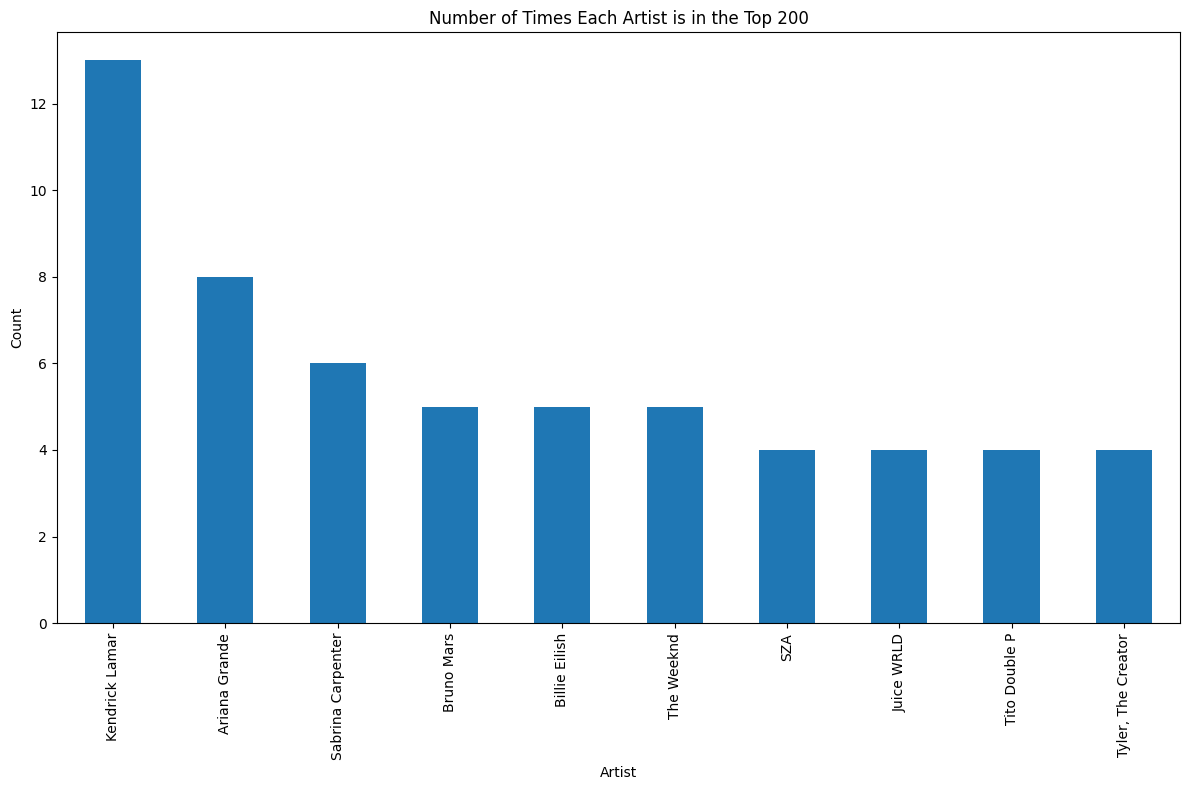

In [6]:
# Plot the data
plt.figure(figsize=(12, 8))
artist_counts.head(10).plot(kind='bar')
plt.title('Number of Times Each Artist is in the Top 200')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
def get_artist_list(artist_name):
    """
    Fetch artist information from the MusicBrainz API.
    """
    endpoint = f"{BASE_URL}/artist"
    params = {
        "query": artist_name,  # Search for the artist by name
        "fmt": "json"         # Request JSON response
    }
    
    try:
        response = requests.get(endpoint, params=params)
        response.raise_for_status()  # Raise an exception for HTTP errors
        data = response.json()
        return data["artists"] if "artists" in data else None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching artist info: {e}")
        return None

In [8]:
def get_artist_info(artist_id):
    """
    Fetch detailed information for a specific artist by ID.
    """
    endpoint = f"{BASE_URL}/artist/{artist_id}"
    params = {
        "inc": "aliases+tags+ratings",  # Include additional information
        "fmt": "json"                   # Request JSON response
    }
    
    try:
        response = requests.get(endpoint, params=params)
        response.raise_for_status()  # Raise an exception for HTTP errors
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching artist data: {e}")
        return None

In [9]:
df_artists = pd.DataFrame(columns=['Artist', 'id', 'Country', 'Type', 'Gender', 'Rating', 'Tags'])
for index, artist_name in enumerate(artist_counts.index):
    
    # Fetch artist data
    artists = get_artist_list(artist_name)
        
    # Search for data of the first artist
    if artists:
        artist = artists[0]
        
        artist_name = artist.get("name")
        artist_type = artist.get("type")
        artist_country = artist.get("country")
        
        artist_id = artist.get("id")
        if artist_id:
            artist_data = get_artist_info(artist_id)
            if artist_data:
                
                gender = artist_data.get("gender")
                rating = artist_data.get("rating")
                tags = artist_data.get("tags")
                
                df_artists.loc[index] = [artist_name, artist_id, artist_country, artist_type, gender, rating, tags]
                               
            else:
                print("No artist data found.")
        else:
            print("No artist ID found.")
    else:
        print("No artist information found.")
        
    time.sleep(1)  # Be polite to the API
        
df_artists

Error fetching artist data: 503 Server Error: Service Temporarily Unavailable for url: https://musicbrainz.org/ws/2/artist/4e4ebde4-0c56-4dec-844b-6c73adcdd92d?inc=aliases%2Btags%2Bratings&fmt=json
No artist data found.
Error fetching artist data: 503 Server Error: Service Temporarily Unavailable for url: https://musicbrainz.org/ws/2/artist/35feae82-8b2c-4f8f-ae7a-af5662848947?inc=aliases%2Btags%2Bratings&fmt=json
No artist data found.
Error fetching artist data: 503 Server Error: Service Temporarily Unavailable for url: https://musicbrainz.org/ws/2/artist/b83bc61f-8451-4a5d-8b8e-7e9ed295e822?inc=aliases%2Btags%2Bratings&fmt=json
No artist data found.
Error fetching artist data: 503 Server Error: Service Temporarily Unavailable for url: https://musicbrainz.org/ws/2/artist/2baf3276-ed6a-4349-8d2e-f4601e7b2167?inc=aliases%2Btags%2Bratings&fmt=json
No artist data found.
Error fetching artist data: 503 Server Error: Service Temporarily Unavailable for url: https://musicbrainz.org/ws/2/arti

,Artist,id,Country,Type,Gender,Rating,Tags
0,Kendrick Lamar,381086ea-f511-4aba-bdf9-71c753dc5077,US,Person,Male,"{'votes-count': 9, 'value': 4.1}","[{'name': 'alternative hip hop', 'count': 1}, ..."
1,Ariana Grande,f4fdbb4c-e4b7-47a0-b83b-d91bbfcfa387,US,Person,Female,"{'value': 4.25, 'votes-count': 11}","[{'name': 'contemporary r&b', 'count': 2}, {'c..."
2,Sabrina Carpenter,1882fe91-cdd9-49c9-9956-8e06a3810bd4,US,Person,Female,"{'votes-count': 4, 'value': 5}","[{'count': 1, 'name': 'alternative pop'}, {'na..."
3,Bruno Mars,afb680f2-b6eb-4cd7-a70b-a63b25c763d5,US,Person,Male,"{'votes-count': 4, 'value': 3.75}","[{'name': '2010s', 'count': 1}, {'count': 4, '..."
4,Billie Eilish,f4abc0b5-3f7a-4eff-8f78-ac078dbce533,US,Person,Female,"{'votes-count': 8, 'value': 3.75}","[{'name': '2010s', 'count': 1}, {'name': '2020..."
...,...,...,...,...,...,...,...
174,Daniel Caesar,b46e298d-d3a5-4695-a03e-63e8c523b23e,CA,Person,Male,"{'value': 4, 'votes-count': 1}","[{'count': 1, 'name': 'alternative r&b'}, {'co..."
175,Cigarettes After Sex,34557d8f-ee4a-44ab-ae6e-49bb8ac604d0,US,Group,None,"{'votes-count': 3, 'value': 3.65}","[{'count': 2, 'name': 'ambient'}, {'name': 'am..."
176,The Pogues,d41a6875-b626-4c0f-89a1-aecb643d29ff,GB,Group,None,"{'votes-count': 5, 'value': 4.2}","[{'name': 'celtic folk music', 'count': 3}, {'..."
177,Kirsty MacColl,f63f2884-56d3-47f3-8a7e-72c324758730,GB,Person,Female,"{'value': 3, 'votes-count': 1}","[{'name': 'british', 'count': 1}, {'name': 'cl..."


In [10]:
# Divide the 'Rating' column in two (value and count)
df_artists['RatingValue'] = df_artists['Rating'].apply(lambda x: x.get('value') if x else None)
df_artists['RatingCount'] = df_artists['Rating'].apply(lambda x: x.get('votes-count') if x else None)

# Remove the 'Rating' column
df_artists.drop(columns=['Rating'], inplace=True)

# Simplify the 'Tags' column (keep only the names)
df_artists['Tags'] = df_artists['Tags'].apply(lambda x: [tag['name'] for tag in x] if x else None)

df_artists

,Artist,id,Country,Type,Gender,Tags,RatingValue,RatingCount
0,Kendrick Lamar,381086ea-f511-4aba-bdf9-71c753dc5077,US,Person,Male,"[alternative hip hop, conscious hip hop, hardc...",4.10,9
1,Ariana Grande,f4fdbb4c-e4b7-47a0-b83b-d91bbfcfa387,US,Person,Female,"[contemporary r&b, dance-pop, pop, r&b, trap s...",4.25,11
2,Sabrina Carpenter,1882fe91-cdd9-49c9-9956-8e06a3810bd4,US,Person,Female,"[alternative pop, electropop, pop]",5.00,4
3,Bruno Mars,afb680f2-b6eb-4cd7-a70b-a63b25c763d5,US,Person,Male,"[2010s, funk, music for soccer moms, pop, r&b,...",3.75,4
4,Billie Eilish,f4abc0b5-3f7a-4eff-8f78-ac078dbce533,US,Person,Female,"[2010s, 2020s, alt-pop, alternative pop, alter...",3.75,8
...,...,...,...,...,...,...,...,...
174,Daniel Caesar,b46e298d-d3a5-4695-a03e-63e8c523b23e,CA,Person,Male,"[alternative r&b, caesar, contemporary r&b, da...",4.00,1
175,Cigarettes After Sex,34557d8f-ee4a-44ab-ae6e-49bb8ac604d0,US,Group,None,"[ambient, ambient pop, androgynous vocals, dre...",3.65,3
176,The Pogues,d41a6875-b626-4c0f-89a1-aecb643d29ff,GB,Group,None,"[celtic folk music, celtic punk, celtic rock, ...",4.20,5
177,Kirsty MacColl,f63f2884-56d3-47f3-8a7e-72c324758730,GB,Person,Female,"[british, classic pop and rock, english, pop r...",3.00,1


In [11]:
# Merge the two dataframes (df_artists and artist_counts)
df_merged = pd.merge(df_artists, artist_counts, left_on='Artist', right_index=True, how='inner')

# Remove lines with missing values for the 'count' column (remove mismatched artists)
df_merged.dropna(subset=['count'], inplace=True)

# Remove duplicate artists
df_merged.drop_duplicates(subset=['Artist'], inplace=True)

df_merged

,Artist,id,Country,Type,Gender,Tags,RatingValue,RatingCount,count
0,Kendrick Lamar,381086ea-f511-4aba-bdf9-71c753dc5077,US,Person,Male,"[alternative hip hop, conscious hip hop, hardc...",4.10,9,13
1,Ariana Grande,f4fdbb4c-e4b7-47a0-b83b-d91bbfcfa387,US,Person,Female,"[contemporary r&b, dance-pop, pop, r&b, trap s...",4.25,11,8
2,Sabrina Carpenter,1882fe91-cdd9-49c9-9956-8e06a3810bd4,US,Person,Female,"[alternative pop, electropop, pop]",5.00,4,6
3,Bruno Mars,afb680f2-b6eb-4cd7-a70b-a63b25c763d5,US,Person,Male,"[2010s, funk, music for soccer moms, pop, r&b,...",3.75,4,5
4,Billie Eilish,f4abc0b5-3f7a-4eff-8f78-ac078dbce533,US,Person,Female,"[2010s, 2020s, alt-pop, alternative pop, alter...",3.75,8,5
...,...,...,...,...,...,...,...,...,...
174,Daniel Caesar,b46e298d-d3a5-4695-a03e-63e8c523b23e,CA,Person,Male,"[alternative r&b, caesar, contemporary r&b, da...",4.00,1,1
175,Cigarettes After Sex,34557d8f-ee4a-44ab-ae6e-49bb8ac604d0,US,Group,None,"[ambient, ambient pop, androgynous vocals, dre...",3.65,3,1
176,The Pogues,d41a6875-b626-4c0f-89a1-aecb643d29ff,GB,Group,None,"[celtic folk music, celtic punk, celtic rock, ...",4.20,5,1
177,Kirsty MacColl,f63f2884-56d3-47f3-8a7e-72c324758730,GB,Person,Female,"[british, classic pop and rock, english, pop r...",3.00,1,1


In [12]:
# Print the number of groups and solo artists
print("Number of groups:", df_merged[df_merged['Type'] == 'Group'].shape[0])
print("Number of solo artists:", df_merged[df_merged['Type'] == 'Person'].shape[0])

# Print the number of male and female artists
print("Number of male artists:", df_merged[df_merged['Gender'] == 'Male'].shape[0])
print("Number of female artists:", df_merged[df_merged['Gender'] == 'Female'].shape[0])

Number of groups: 26
Number of solo artists: 92
Number of male artists: 62
Number of female artists: 29


Premières visualisations (graphiques et statistiques) pour déterminer les tendances uniquement à partir des données du classement Billboard200

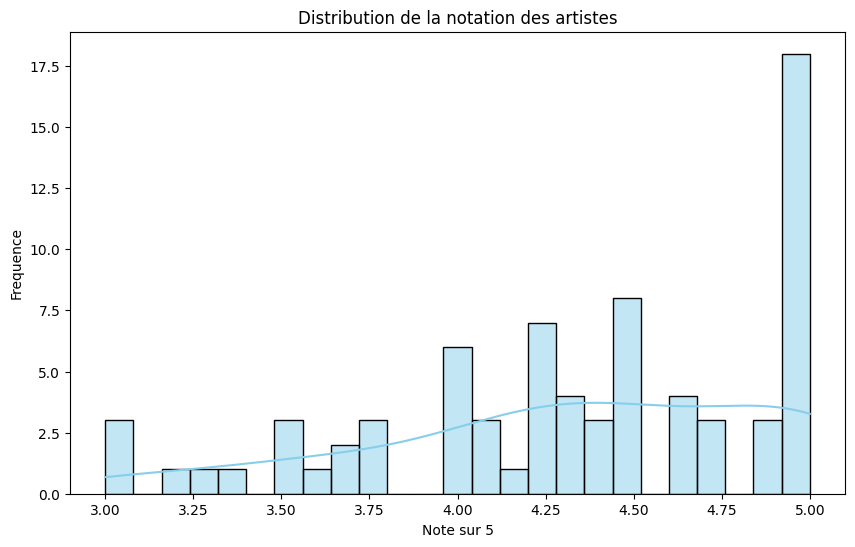

In [13]:
#Histogrammes (visualisation) pour déterminer les tendances

import matplotlib.pyplot as plt
import seaborn as sns

# Histogramme des RatingValue
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['RatingValue'].dropna(), kde=True, bins=25, color='skyblue')
plt.title('Distribution de la notation des artistes')
plt.xlabel('Note sur 5')
plt.ylabel('Frequence')
plt.show()



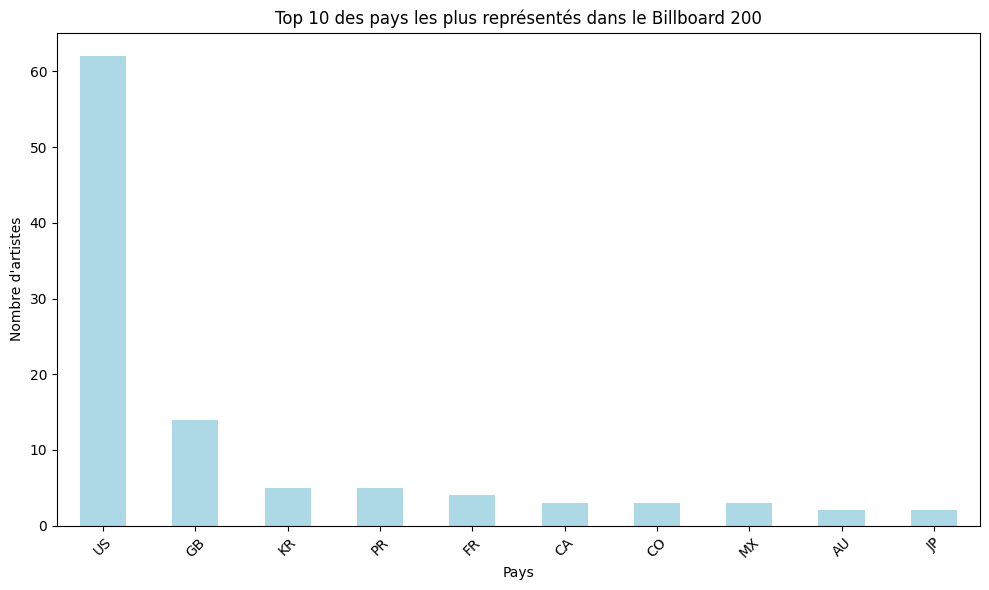

In [14]:
# Les 10 pays les plus représentés
country_counts = df_merged['Country'].value_counts().head(10)  

# Histogramme
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='lightblue')
plt.title('Top 10 des pays les plus représentés dans le Billboard 200')
plt.xlabel('Pays')
plt.ylabel('Nombre d\'artistes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\enriq\AppData\Local\Temp\ipykernel_30268\4057551535.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette="Set1")


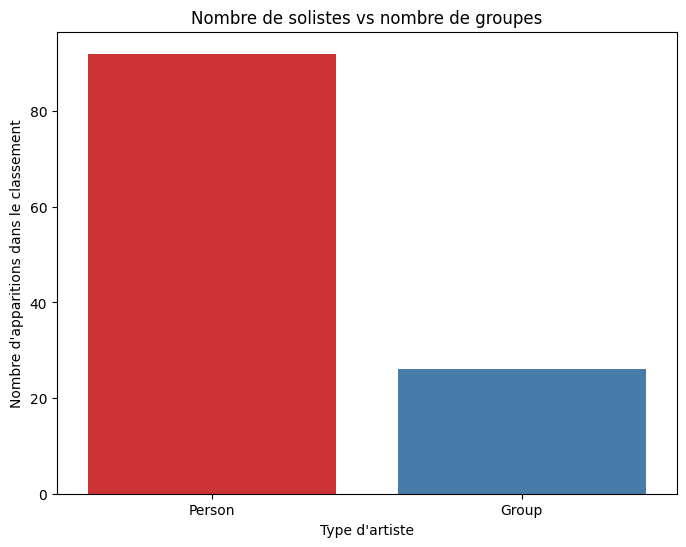

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# On compte le nombre de groupes et de solistes
type_counts = df_merged['Type'].value_counts()

# Le diagramme a barres
plt.figure(figsize=(8, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette="Set1")
plt.title('Nombre de solistes vs nombre de groupes')
plt.xlabel("Type d'artiste")
plt.ylabel("Nombre d'apparitions dans le classement")
plt.show()


C:\Users\enriq\AppData\Local\Temp\ipykernel_30268\2596082682.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='RatingValue', data=df_merged, palette="Set1")


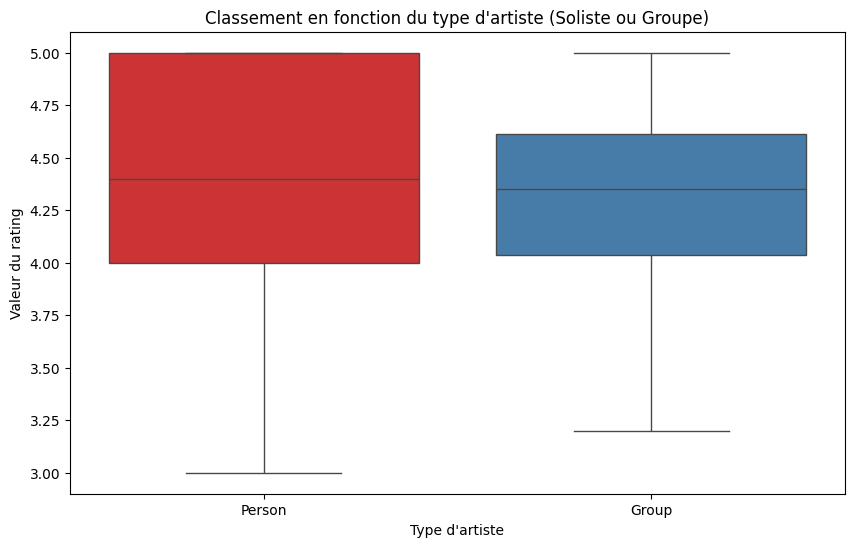

In [25]:
# Box plot pour le type d'artiste
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='RatingValue', data=df_merged, palette="Set1")
plt.title("Classement en fonction du type d'artiste (Soliste ou Groupe)")
plt.xlabel("Type d'artiste")
plt.ylabel('Valeur du rating')
plt.show()


C:\Users\enriq\AppData\Local\Temp\ipykernel_30268\4166482494.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="Set2")


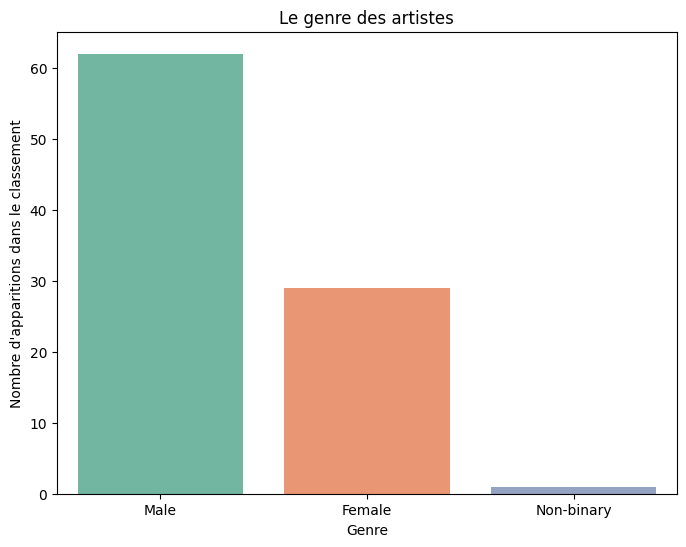

In [27]:
# Le genre des artistes
gender_counts = df_merged['Gender'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="Set2")
plt.title('Le genre des artistes')
plt.xlabel('Genre')
plt.ylabel("Nombre d'apparitions dans le classement")
plt.show()


In [18]:
def search_genius(query):
    """
    Search the Genius API for songs, artists, or albums.
    """
    endpoint = f"{GENIUS_URL}/search"
    headers = {
        "Authorization": f"Bearer {API_TOKEN}"
    }
    params = {
        "q": query  # The search term
    }
    
    try:
        response = requests.get(endpoint, headers=headers, params=params)
        response.raise_for_status()  # Raise HTTP errors if any
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error searching Genius API: {e}")
        return None

In [19]:
def get_lyrics(song_id):
    """
    Fetch the lyrics for a specific song by ID.
    """
    endpoint = f"{GENIUS_URL}/songs/{song_id}"
    headers = {
        "Authorization": f"Bearer {API_TOKEN}"
    }
    
    try:
        response = requests.get(endpoint, headers=headers)
        response.raise_for_status()  # Raise HTTP errors if any
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching lyrics: {e}")
        return None

In [20]:
def find_lyrics(url):
    """
    Extract lyrics from a Genius URL.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTP errors if any
        soup = BeautifulSoup(response.text, "html.parser")
        lyrics = soup.find("div", class_="Lyrics__Container-sc-1ynbvzw-1 kUgSbL").get_text(separator="\n")
        lyrics = "\n".join([element.get_text(separator="\n") for element in soup.find_all("div", class_="Lyrics__Container-sc-1ynbvzw-1 kUgSbL")])
        # Delete the indications in [] and ()
        lyrics = re.sub(r"[\(\[].*?[\)\]]", "", lyrics, flags=re.DOTALL)
        return lyrics
    except requests.exceptions.RequestException as e:
        print(f"Error fetching lyrics: {e}")
        return None

In [21]:
for song_name in dataframe['Song']:
    # Search for the song
    search_results = search_genius(song_name)
    
    # Check if the search was successful
    if search_results:
        # Get the first search result
        search_hits = search_results.get("response", {}).get("hits")
        if search_hits:
            search_hit = search_hits[0]
            
            # Get the song ID
            song_id = search_hit.get("result", {}).get("id")
            
            # Get the song URL
            song_url = search_hit.get("result", {}).get("url")
            
            # Get the song lyrics
            lyrics = find_lyrics(song_url)
            
            # Store the song lyrics
            dataframe.loc[dataframe['Song'] == song_name, 'Lyrics'] = lyrics
            
            time.sleep(0.5)  # Be polite to the API
            
dataframe

AttributeError: 'NoneType' object has no attribute 'get_text'

Tentative NLP en fonction des paroles des chansons les plus célèbres

In [29]:
#Installations préalables
%pip install pywaffle
%pip install spacy
%pip install plotnine
%pip install great_tables
%pip install wordcloud


   ---------------------------------------- 0.0/25.6 MB ? eta -:--:--
   - -------------------------------------- 0.8/25.6 MB 4.2 MB/s eta 0:00:06
   -- ------------------------------------- 1.6/25.6 MB 4.0 MB/s eta 0:00:06
   --- ------------------------------------ 2.1/25.6 MB 3.5 MB/s eta 0:00:07
   ---- ----------------------------------- 2.9/25.6 MB 3.6 MB/s eta 0:00:07
   ----- ---------------------------------- 3.7/25.6 MB 3.7 MB/s eta 0:00:07
   ------- -------------------------------- 4.7/25.6 MB 3.9 MB/s eta 0:00:06
   -------- ------------------------------- 5.8/25.6 MB 4.0 MB/s eta 0:00:05
   ---------- ----------------------------- 6.6/25.6 MB 4.1 MB/s eta 0:00:05
   ----------- ---------------------------- 7.6/25.6 MB 4.2 MB/s eta 0:00:05
   ------------- -------------------------- 8.7/25.6 MB 4.2 MB/s eta 0:00:05
   -------------- ------------------------- 9.4/25.6 MB 4.2 MB/s eta 0:00:04
   ---------------- ----------------------- 10.5/25.6 MB 4.3 MB/s eta 0:00:04
   -

  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [120 lines of output]
      Ignoring numpy: markers 'python_version < "3.9"' don't match your environment
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached murmurhash-1.0.11-cp313-cp313-win_amd64.whl.metadata (2.0 kB)
        Installing build dependencies: started
        Installing build dependencies: still running...
        Installing build dependencies: finished with status 'error'
        error: subprocess-exited-with-error
      
        Ã— pip subprocess to install build dependencies did not run successfully.
  


   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------------------------ --------------- 0.8/1.3 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.5/44.5 MB 5.4 MB/s eta 0:00:09
   - -------------------------------------- 1.3/44.5 MB 3.6 MB/s eta 0:00:12
   -- ------------------------------------- 2.4/44.5 MB 4.0 MB/s eta 0:00:11
   --- ------------------------------------ 3.4/44.5 MB 4.2 MB/s eta 0:00:10
   --- ------------------------------------ 4.2/44.5 MB 4.2 MB/s eta 0:00:10
   ---- ----------------------------------- 5.5/44.5 MB 4.3 MB/s eta 0:00:10
   ----- ---------------------------------- 6.3/44.5 MB 4.3 MB/s eta 0:00:09
   ------ --------------------------------- 7.3/44.5 MB 4.4 MB/s eta 0:00:09
   ------- -------------------------------- 8.1/44.5 MB 4.4 MB/s eta 0:00:09
   -------- ---

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [30]:
#Nettoyage du texte
import spacy

def clean_text(doc):
    cleaned_tokens = [
     

ModuleNotFoundError: No module named 'spacy'